# This Notebook demonstrates how the three methods (NN, K-NN and Verde Biharmonic spline) were evaluated. It also illustrates the importance of tuning the damping and mindist for the Spline method.

This Notebook was implemented following the work in https://pygis.io/docs/e_interpolation.html and https://www.fatiando.org/verde/latest/gallery/spline_cv.html

In [2]:
import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pyproj
from sklearn.model_selection import ShuffleSplit
import geopandas as gpd
import verde as vd
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from shapely import wkt
from shapely.geometry import Point, MultiPoint, box, Polygon
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import xarray as xr
import itertools
import rioxarray
import xarray as xr
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname='/kaggle/input/book-antiqua/BookAntiquaFont.ttf',
    name='Book Antiqua')
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name
matplotlib.rcParams.update({'font.size': 16})

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Load the image and wind speed points

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1024, 'height': 1024, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(40.0, 0.0, 338614.24926506815,
       0.0, -40.0, 4837175.67755162), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'band'}
EPSG:32610
40.0
338614.24926506815
4837175.67755162


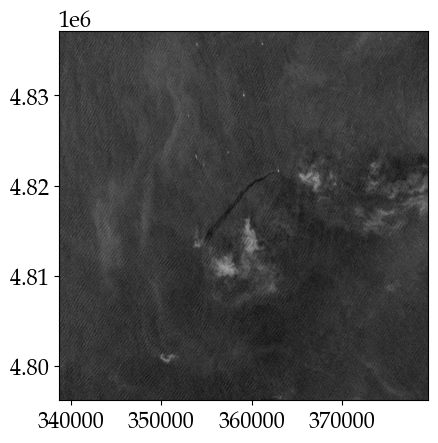

In [3]:
folder_path = '/kaggle/input/oilspill-55/20211018T021703_Orb_Msk_Thm_Cal_Spk_db_40m_UTM_1024px.tif'

with rasterio.open(folder_path) as dataset:
    print(dataset.profile)

    proj = dataset.crs
    print(proj)

    xsize = dataset.width

    ysize = dataset.height

    transform = dataset.transform

    resolution = transform[0]
    print(resolution)

    ulx = transform[2]
    print(ulx)
    
    uly = transform[5]
    print(uly)

    image = rasterio.open(folder_path)
    show(image, cmap='gray')

lrx = ulx + xsize * resolution
lry = uly - ysize * resolution

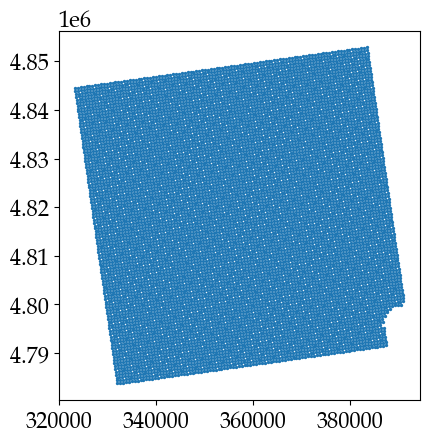

In [4]:
csv_path = r'/kaggle/input/oilspill-55/WindField.csv'
df = pd.read_csv(csv_path, skiprows=4, delimiter="\t")
# Convert the WKT format points to Shapely Point objects
df['geometry'] = df.iloc[:, 2].apply(wkt.loads)
# Create a GeoDataFrame from the Pandas dataframe
points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=proj)
# Plot the points on a map
ax = points_gdf.plot(markersize=2)
# Show the map
plt.show()

In [5]:
image_bounds = image.bounds
# print(image_bounds)
image_bb = box(*image_bounds)
# print(image_bb.wkt)
boundary_gdf = gpd.GeoDataFrame({"geometry":[image_bb]},crs=proj)
boundary_gdf.to_file("image1_boundary.gpkg", driver="GPKG")
# print(boundary_gdf)

points_clip = gpd.clip(points_gdf, boundary_gdf)
print(points_clip.head())
# points_clip = points_gdf
# print(points_clip)

# ax = boundary_gdf.plot()
# Show the map
plt.show()

     org.esa.snap_geometry_04Mar2023T21.22.59 WindField:String  \
1878                               ID00001878        wind_2414   
1879                               ID00001879        wind_2415   
1880                               ID00001880        wind_2416   
1888                               ID00001888        wind_2423   
1889                               ID00001889        wind_2424   

                                   geometry:Point  speed:Double  \
1878     POINT (344176.248453318 4796495.6344033)           0.1   
1879   POINT (344770.1920189694 4796579.86476789)           6.7   
1880  POINT (345364.3971864246 4796663.178032759)           3.7   
1888  POINT (344089.4372186905 4797096.758344056)           4.7   
1889  POINT (344683.3822879032 4797180.977855558)           0.1   

      heading:Double  dx:Double  dy:Double  ratio:Double  \
1878       -1.000000        0.0        0.0           0.0   
1879      350.502049        0.0       20.0           1.0   
1880      260.676274

In [6]:
# Get X and Y coordinates of wind field points
x_wind = points_clip["geometry"].x
# print(x_wind)
y_wind = points_clip["geometry"].y
# print(y_wind)

outputBounds = [ulx,lrx,lry,uly]
print(outputBounds)

extent = x_min, x_max, y_min, y_max = [points_clip["geometry"].x.min(), points_clip["geometry"].x.max(),
                                       points_clip["geometry"].y.min(),points_clip["geometry"].y.max()]
print(extent)
# Create list of XY coordinate pairs
coords_wind = [list(xy) for xy in zip(x_wind, y_wind)]
coords_wind_arr = np.array(coords_wind)

# get list of wind speed values
value_wind = list(points_clip.iloc[:,3])
value_wind_arr = np.array(value_wind)

[338614.24926506815, 379574.24926506815, 4796215.67755162, 4837175.67755162]
[338620.4828779205, 379572.7213513168, 4796216.57225372, 4837174.082071224]


In [7]:
coords_wind_arr = np.moveaxis(coords_wind_arr,0, -1)
print(coords_wind_arr.shape)

(2, 4608)


# Splitting the data

In [8]:
train, test = vd.train_test_split(
    coords_wind_arr, value_wind_arr, test_size=0.2, random_state=0
)

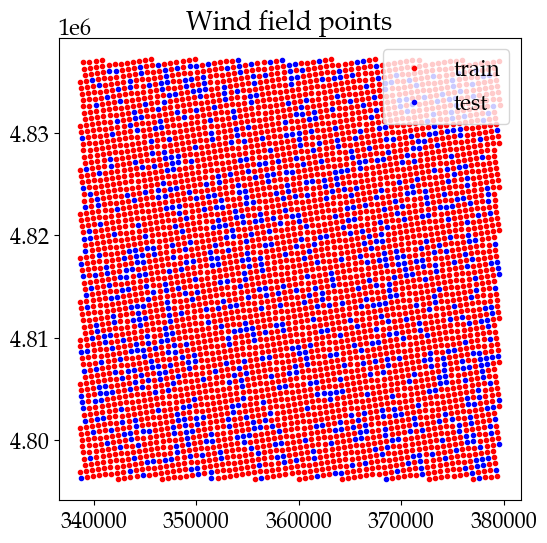

In [9]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.set_title("Wind field points", fontweight="bold")
ax.plot(train[0][0], train[0][1], ".r", label="train")
ax.plot(test[0][0], test[0][1], ".b", label="test")
ax.legend()
plt.xticks()
plt.yticks()
ax.set_aspect("equal")
plt.savefig('wind field points train test example.png', dpi=600, format='png')
plt.show()

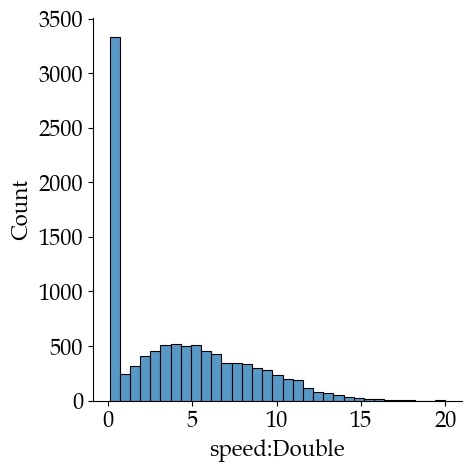

In [10]:
sns.displot(df['speed:Double'])

# Thiessen Polygons (Voronoi Diagrams)

Thiessen polygons, also called Voronoi diagrams, are useful for performing nearest neighbor interpolation, which is a basic type of interpolation. By constructing a polygon around each sample point, we can assign all the space within that polygon to be closest in distance to that particular point compared to other sample points. This allows us to assign the value of that sample point to all the space within its polygon, thereby performing nearest neighbor interpolation. To create Thiessen polygons, we can utilize the scipy package and its Voronoi() function, which generates a list of vertices that can be used to generate the polygons.

In [11]:
# Split data into testing and training sets
coords_wind_train, coords_wind_test, value_wind_train, value_wind_test = train_test_split(coords_wind, value_wind, test_size = 0.20, random_state = 0)

# Create separate GeoDataFrames for testing and training sets
wind_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_wind_train], crs = proj)
# print(wind_train_gdf)
# print('---')
wind_train_gdf["Actual_Value"] = value_wind_train
# print(wind_train_gdf)
# print('---')
wind_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_wind_test], crs = proj)
# print(wind_test_gdf)
# print('---')
wind_test_gdf["Actual_Value"] = value_wind_test
# print(wind_test_gdf)
# print('---')
# Get minimum and maximum coordinate values of wind speed training points
min_x_wind, min_y_wind, max_x_wind, max_y_wind = wind_train_gdf.total_bounds

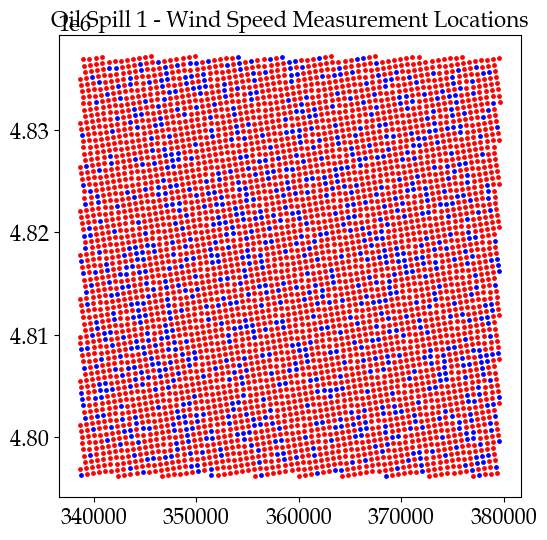

In [12]:
##### Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

# Plot data
wind_train_gdf.plot(ax = ax, marker = '.', color = 'red', markersize = 24)
wind_test_gdf.plot(ax = ax, marker = '.', color = 'blue', markersize = 24)
# Set title
ax.set_title('Oil Spill 1 - Wind Speed Measurement Locations', fontdict = {'fontsize': '16', 'fontweight' : '3'})
ax.set_aspect("equal")
plt.show()

In [13]:
# Extend extent image boundary feature by using buffer
boundary_buffer = boundary_gdf.buffer(100000)

# Get extent of buffered input feature
min_x_bdry_tp, min_y_bdry_tp, max_x_bdry_tp, max_y_bdry_tp = boundary_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_wind_train + [[min_x_bdry_tp, min_y_bdry_tp], [max_x_bdry_tp, min_y_bdry_tp],
                                 [max_x_bdry_tp, max_y_bdry_tp], [min_x_bdry_tp, max_y_bdry_tp]]
# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi polygons
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
for region in tp.regions:

    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:

        # Return to top of loop
        continue

    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:

        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)

    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs =proj)

# Clip polygon regions to the image boundary
tp_polys_clipped = gpd.clip(tp_polys, boundary_gdf)

A spatial join can be conducted to assign the wind speed training “values” to its associated Thiessen polygon.

In [14]:
# If wind measurement point within the polygon, assign that wind speed value to the polygon
tp_polys_clipped_values = gpd.sjoin(wind_train_gdf, tp_polys_clipped, how = "right", predicate = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)

# Rename column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

# Display head of attribute table
print("Attribute Table: Thiessen Polygon Interpolated Values")
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


,VALUE_Thiessen,geometry
263,4.2,"POLYGON ((360223.658 4796612.020, 360279.376 4..."
267,0.1,"POLYGON ((360223.658 4796612.020, 360815.154 4..."
262,0.1,"POLYGON ((359389.774 4796215.678, 359065.156 4..."
269,0.1,"POLYGON ((360221.009 4796613.984, 359627.178 4..."
268,0.1,"POLYGON ((360728.340 4797298.292, 360730.921 4..."


To obtain the out-of-sample r-squared value, we can perform another spatial join by associating the values obtained from the Thiessen polygons to the points of the testing dataset, but only for those testing points that lie within a polygon. This allows us to use the testing dataset, which was not used to train the model, to evaluate the performance of the model by comparing the actual values of the testing points with the values predicted by the model.

In [15]:
# If test point is within a polygon, assign that polygon's value to the test point
wind_test_pred_tp = gpd.sjoin(wind_test_gdf, tp_polys_clipped_values, how = "left", predicate = 'within')
# print(wind_test_pred_tp)

# Drop un-needed column
wind_test_pred_tp = wind_test_pred_tp.drop("index_right", axis = 1)
# print(wind_test_pred_tp)

# Rename column
wind_test_pred_tp = wind_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})
# print(wind_test_pred_tp)

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(wind_test_pred_tp.VALUE_Actual, wind_test_pred_tp.VALUE_Predict)
print("Thiessen polygon out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method")
display(wind_test_pred_tp.head(2))

Thiessen polygon out-of-sample r-squared: -0.96

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


,geometry,VALUE_Actual,VALUE_Predict
0,POINT (372461.444 4823155.499),0.1,2.9
1,POINT (358484.143 4810774.035),7.5,14.9


When we create a plot of the data, we can observe that each Thiessen polygon corresponds to a single green training point, and the reverse is also true. The space within each polygon is nearest to the training point represented by the green dot within the polygon. The testing points, represented by blue dots, are given the value of the Thiessen polygon in which they fall.

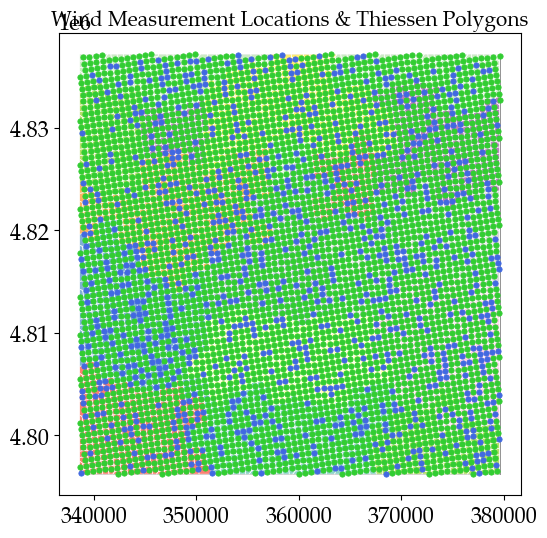

In [16]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

# Stylize plots
plt.style.use('bmh')

# Plot data
boundary_gdf.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
tp_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
wind_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
wind_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

# Set title
ax.set_title('Wind Measurement Locations & Thiessen Polygons', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

The following example illustrates how to obtain the value of a Thiessen polygon at a new location to predict a value. The point_region attribute is used to determine the index of the Voronoi region to which the point belongs. This index is then used to retrieve the corresponding region in the regions. The retrieved region provides the indices of the vertices that form the polygon, which can be used to obtain the appropriate values in the vertices.

In [17]:
# Set index for feature of interest
feature_index_one = 5

# Get a Voronoi polygon for one feature
# 'point_region' attribute provides the index of the Voronoi region belonging to a specified point
# Can use the index to call the appropriate element in the 'regions' attribute
tp_poly_region_one = Polygon(tp.vertices[tp.regions[tp.point_region[feature_index_one]]])

# Create GeoDataFrame for polygon
tp_poly_region_one = gpd.GeoDataFrame([tp_poly_region_one], columns = ['geometry'], crs = proj)

# Clip polygon to county boundary
tp_poly_region_one = gpd.clip(tp_poly_region_one, boundary_gdf)

# Get the equivalent feature from the rainfall dataset
wind_one = wind_train_gdf.iloc[[feature_index_one]]

# Add the rainfall value to the polygon attribute table
tp_poly_region_one["VALUE_Predict"] = wind_one["Actual_Value"].values

# Display attribute table
print("Attribute Table: Thiessen Polygon Interpolated Value")
display(tp_poly_region_one)

Attribute Table: Thiessen Polygon Interpolated Value


,geometry,VALUE_Predict
0,"POLYGON ((371449.560 4819645.142, 371365.673 4...",0.1


Here’s how that one Thiessen polygon looks.

Text(0.5, 1.0, 'One Point and Thiessen Polygon')

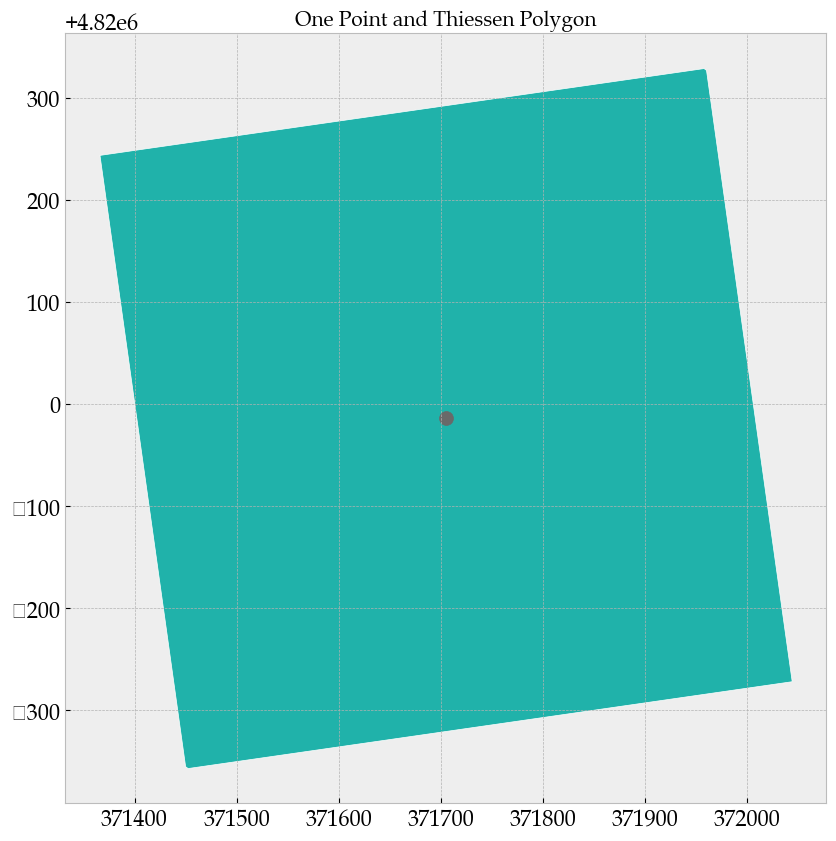

In [18]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
tp_poly_region_one.plot(ax = ax, color = 'lightseagreen', edgecolor = 'white', linewidth = 0.5)
wind_one.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 100)

# Set title
ax.set_title('One Point and Thiessen Polygon', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# K-Nearest Neighbors
KNN, short for k-nearest neighbors, is a type of neighbor-based learning method that can also be utilized for interpolation. This method differs from Thiessen polygons in that it searches for K number of sampled points that are closest to an unknown point. These K known points can then be used to estimate the value, whether it is a discrete or continuous variable, of the unknown point.

In [19]:
# Set number of neighbors to look for
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(np.array(coords_wind_train), np.array(value_wind_train))

KNeighborsRegressor(weights='distance')

Now that we have created the KNN model, we can get the in-sample r-squared value. An in-sample statistic, as suggested by its name, is calculated by using the data that were used to build the model (the “training” dataset).

In [20]:
# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(np.array(coords_wind_train), np.array(value_wind_train))
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

KNN in-sample r-squared: 1.0


Here, the in-sample r-squared value is 100% because KNN is a “exact interpolator.” For exact interpolators, estimated values for known points are exactly equal to actual values. Other methods like Kriging, shown below, are inexact interpolators. For inexact interpolators, estimated values for known points are not exactly equal to actual values. Here’s a visual of inexact versus exact interpolators.

Similarily, we can also get the out-of-sample r-squared value and compare the test dataset’s actual values to the values as predicted by the model.

In [21]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(np.array(coords_wind_test), np.array(value_wind_test))
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_wind_test_predict_knn = knn_regressor.predict(np.array(coords_wind_test))

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_wind_test, "VALUE_Actual": value_wind_test, "VALUE_Predict": coords_wind_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(2))

KNN out-of-sample r-squared: -0.16

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[372461.44391571905, 4823155.498922095]",0.1,4.819426
1,"[358484.1434960831, 4810774.034811921]",7.5,9.702577


# Verde Spline

The Green’s functions based interpolations in Verde are all linear regressions under the hood. This means that we can use some of the same tactics from sklearn.model_selection to evaluate our interpolator’s performance. Once we have a quantified measure of the quality of a given fitted gridder, we can use it to tune the gridder’s parameters, like damping for a Spline (see Model Selection).

Verde provides adaptations of common scikit-learn tools to work better with spatial data.

We can pass the training dataset to the fit method of most gridders using Python’s argument expansion using the * symbol.

In [22]:
spline = vd.Spline()
spline.fit(*train)

Spline()

Create a grid.

In [23]:
grid = spline.grid(
    region=outputBounds,
    shape=(1024,1024),
    pixel_register=True,
    data_names='wind_speed',
)
print(grid)

<xarray.Dataset>
Dimensions:     (northing: 1024, easting: 1024)
Coordinates:
  * easting     (easting) float64 3.386e+05 3.387e+05 ... 3.795e+05 3.796e+05
  * northing    (northing) float64 4.796e+06 4.796e+06 ... 4.837e+06 4.837e+06
Data variables:
    wind_speed  (northing, easting) float64 -2.38 -2.323 -2.269 ... 5.44 5.543
Attributes:
    metadata:  Generated by Spline()


Let’s plot the gridded result to see what it looks like.

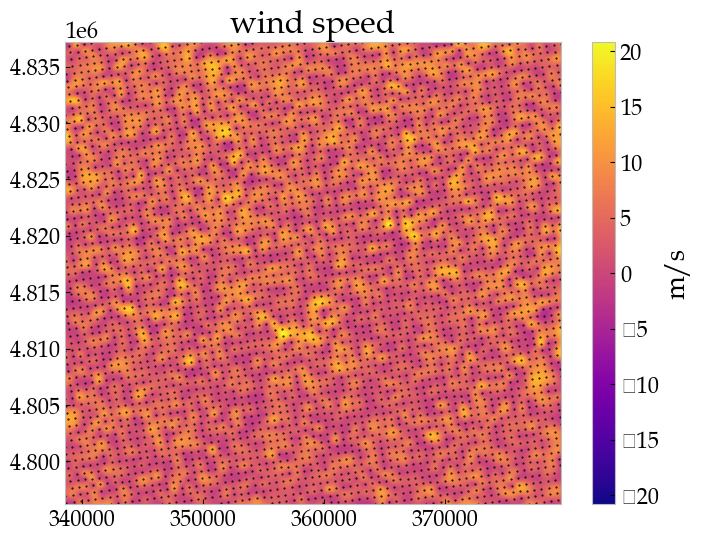

In [24]:
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.set_title("wind speed")
pc = grid.wind_speed.plot.pcolormesh(
    ax=ax,
    cmap="plasma",
    add_colorbar=False,
    add_labels=False,
)
plt.colorbar(pc).set_label("m/s")
ax.plot(x_wind, y_wind, ".k", markersize=1)
plt.show()

# Scoring

Gridders in Verde implement the score method that calculates the R² coefficient of determination for a given comparison dataset (test in our case). The R² score is at most 1, meaning a perfect prediction, but has no lower bound.

In [25]:
score = spline.score(*test)
print("R² score:", score)

R² score: -0.5065293564915698


We can verify the quality of the fit by inspecting a histogram of the residuals with respect to the original data. Remember that our spline and trend were fit on decimated data, not the original data, so the fit won’t be perfect.

In [26]:
ws = grid['wind_speed']
ws = ws.rio.set_spatial_dims(x_dim='easting',y_dim='northing')
print(ws.rio.crs)
ws.rio.write_crs("epsg:32636", inplace=True)
print(ws.rio.crs)
ws.rio.to_raster(raster_path="grid_test2.tif")

None
EPSG:32636


In [27]:
grid = None

Once caveat for this score is that it is highly dependent on the particular split that we made. Changing the random number generator seed in verde.train_test_split will result in a different score.

In [28]:
# Use 1 as a seed instead of 0
train_other, test_other = vd.train_test_split(
    coords_wind_arr, value_wind_arr, test_size=0.1, random_state=1
)

print("R² score with seed 1:", vd.Spline().fit(*train_other).score(*test_other))

R² score with seed 1: -0.6025073445168723


# Cross-validation
A more robust way of scoring the gridders is to use function verde.cross_val_score, which (by default) uses a k-fold cross-validation by default. It will split the data k times and return the score on each fold. We can then take a mean of these scores.

In [29]:
scores = vd.cross_val_score(vd.Spline(), coords_wind_arr, value_wind_arr)
print("k-fold scores:", scores)
print("Mean score:", np.mean(scores))

k-fold scores: [-0.50652936 -0.49926329 -0.44186423 -0.47819259 -0.70285452]
Mean score: -0.5257407994213433


You can also use most cross-validation splitter classes from sklearn.model_selection by specifying the cv argument. For example, if we want to shuffle then split the data n times (sklearn.model_selection.ShuffleSplit):

In [30]:
shuffle = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

scores = vd.cross_val_score(
    vd.Spline(), coords_wind_arr, value_wind_arr, cv=shuffle
)
print("shuffle scores:", scores)
print("Mean score:", np.mean(scores))

shuffle scores: [-0.50788683 -0.47472228 -0.50028722 -0.62666086 -0.58228358 -0.58281748
 -0.53757541 -0.5740952  -0.44975188 -0.46444167]
Mean score: -0.5300522414041761


# Parallel cross-validation
Cross-validation involves running several model fit and score operations which are independent of each other. Because of this, they are prime targets for parallelization. Verde uses the excellent Dask library for parallel execution.

To run verde.cross_val_score with Dask, use the delayed argument:

In [31]:
scores = vd.cross_val_score(
    vd.Spline(), coords_wind_arr, value_wind_arr, delayed=True
)
print("Delayed k-fold scores:", scores)

Delayed k-fold scores: [Delayed('fit_score-bddfbc76-313b-4807-88a6-a12a88ba3dfb'), Delayed('fit_score-e489122d-08ea-4fdc-a83b-ef3c7a2dbbb3'), Delayed('fit_score-cd6c4779-060d-42cd-a2e5-f6b729c32816'), Delayed('fit_score-f3b6a514-a909-471b-94b4-a62ae7678509'), Delayed('fit_score-aec78d34-37c6-4df9-bab2-7800975010b9')]


In this case, the scores haven’t actually been computed yet (hence the “delayed” term). Instead, Verde scheduled the operations with Dask. Since we are interested only in the mean score, we can schedule the mean as well using dask.delayed:

In [32]:
mean_score = dask.delayed(np.mean)(scores)
print("Delayed mean:", mean_score)

Delayed mean: Delayed('mean-91fdbfdd-1b53-46c9-8eec-01ca37efcd82')


To run the scheduled computations and get the mean score, use dask.compute or .compute(). Dask will automatically execute things in parallel.

In [33]:
mean_score = mean_score.compute()
print("Mean score:", mean_score)

Mean score: -0.5257407994213433


Note: Dask will run many fit operations in parallel, which can be memory intensive. Make sure you have enough RAM to run multiple fits.

# Improving the score
That score is not bad but it could be better. The default arguments for Spline aren’t optimal for this dataset. We could try different combinations manually until we get a good score. A better way is to do this automatically. In Model Selection we’ll go over how to do just that.

# Model Selection

In Evaluating Performance, we saw how to check the performance of an interpolator using cross-validation. We found that the default parameters for verde.Spline are not good for predicting our wind speed data. Now, let’s see how we can tune the Spline to improve the cross-validation performance.

Before we begin tuning, let’s reiterate what the results were with the default parameters.

In [34]:
spline_default = vd.Spline()
score_default = np.mean(
    vd.cross_val_score(spline_default, coords_wind_arr, value_wind_arr)
)
spline_default.fit(coords_wind_arr, value_wind_arr)
print("R² with defaults:", score_default)

R² with defaults: -0.5257407994213433


# Tuning
Spline has many parameters that can be set to modify the final result. Mainly the damping regularization parameter and the mindist “fudge factor” which smooths the solution. Would changing the default values give us a better score?

We can answer these questions by changing the values in our spline and re-evaluating the model score repeatedly for different values of these parameters. Let’s test the following combinations:

In [35]:
dampings = [None, 1e-3, 1e-2]
mindists = [5e3, 10e3]

# Use itertools to create a list with all combinations of parameters to test
parameter_sets = [
    dict(damping=combo[0], mindist=combo[1])
    for combo in itertools.product(dampings, mindists)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 6
Combinations: [{'damping': None, 'mindist': 5000.0}, {'damping': None, 'mindist': 10000.0}, {'damping': 0.001, 'mindist': 5000.0}, {'damping': 0.001, 'mindist': 10000.0}, {'damping': 0.01, 'mindist': 5000.0}, {'damping': 0.01, 'mindist': 10000.0}]


Now we can loop over the combinations and collect the scores for each parameter set.

In [36]:
spline = vd.Spline()
scores = []
for params in parameter_sets:
    spline.set_params(**params)
    score = np.mean(vd.cross_val_score(spline, coords_wind_arr, value_wind_arr))
    scores.append(score)
print(scores)

[-0.2482199281207697, -0.2484328558560084, -0.05770089746618341, -0.09552471957797168, -0.013038301334869162, -0.03166760848220442]


The largest score will yield the best parameter combination.

In [37]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Score with defaults:", score_default)
print("Best parameters:", parameter_sets[best])

Best score: -0.013038301334869162
Score with defaults: -0.5257407994213433
Best parameters: {'damping': 0.01, 'mindist': 5000.0}


**That is a nice improvement over our previous score!**

This type of tuning is important and should always be performed when using a new gridder or a new dataset. However, the above implementation requires a lot of coding. Fortunately, Verde provides convenience classes that perform the cross-validation and tuning automatically when fitting a dataset.

# Cross-validated gridders
The verde.SplineCV class provides a cross-validated version of verde.Spline. It has almost the same interface but does all of the above automatically when fitting a dataset. The only difference is that you must provide a list of damping and mindist parameters to try instead of only a single value:

In [38]:
spline = vd.SplineCV(
    dampings=dampings,
    mindists=mindists,
)

Calling fit will run a grid search over all parameter combinations to find the one that maximizes the cross-validation score.

In [39]:
spline.fit(coords_wind_arr, value_wind_arr)

SplineCV(dampings=[None, 0.001, 0.01], mindists=[5000.0, 10000.0])

In [40]:
print("Highest score:", spline.scores_.max())
print("Best damping:", spline.damping_)
print("Best mindist:", spline.mindist_)

Highest score: -0.013038301334869162
Best damping: 0.01
Best mindist: 5000.0


The cross-validated gridder can be used like any other gridder (including in verde.Chain and verde.Vector):

In [41]:
grid = spline.grid(
 region=extent,
    shape= (1024,1024),
    data_names='wind_speed'
)
print(grid)

<xarray.Dataset>
Dimensions:     (northing: 1024, easting: 1024)
Coordinates:
  * easting     (easting) float64 3.386e+05 3.387e+05 ... 3.795e+05 3.796e+05
  * northing    (northing) float64 4.796e+06 4.796e+06 ... 4.837e+06 4.837e+06
Data variables:
    wind_speed  (northing, easting) float64 3.319 3.332 3.346 ... 4.743 4.745
Attributes:
    metadata:  Generated by SplineCV(dampings=[None, 0.001, 0.01], mindists=[...


Like verde.cross_val_score, SplineCV can also run the grid search in parallel using Dask by specifying the delayed attribute:

In [42]:
spline = vd.SplineCV(dampings=dampings, mindists=mindists, delayed=True)

Unlike verde.cross_val_score, calling fit does not result in dask.delayed objects. The full grid search is executed and the optimal parameters are found immediately.

In [43]:
spline.fit(coords_wind_arr, value_wind_arr)

print("Best damping:", spline.damping_)
print("Best mindist:", spline.mindist_)

Best damping: 0.01
Best mindist: 5000.0


The one caveat is the that the scores_ attribute will be a list of dask.delayed objects instead because the scores are only computed as intermediate values in the scheduled computations.

In [44]:
print("Delayed highest score:", spline.scores_)

Delayed highest score: [Delayed('mean-79d03fdc-f390-4bdc-acf7-511fdd2836bb'), Delayed('mean-21e8b74c-f720-4960-bb9b-a2196609eb0c'), Delayed('mean-9c2995cb-635a-47e1-ba83-74fb67b7cf6d'), Delayed('mean-bda4d78e-d568-4b15-acac-b4a5a54526c7'), Delayed('mean-8889140b-ce92-4ca6-a31c-66e303884452'), Delayed('mean-aa0f708c-8500-4f85-8176-6a787946dd86')]


Calling dask.compute on the scores will calculate their values but will unfortunately run the entire grid search again. So using delayed=True is not recommended if you need the scores of each parameter combination.

# The importance of tuning
To see the difference that tuning has on the results, we can make a grid with the best configuration and see how it compares to the default result.

In [45]:
grid_default = spline_default.grid(
 region=extent,
    shape= (1024,1024),
    data_names='wind_speed'
)

Let’s plot our grids side-by-side:

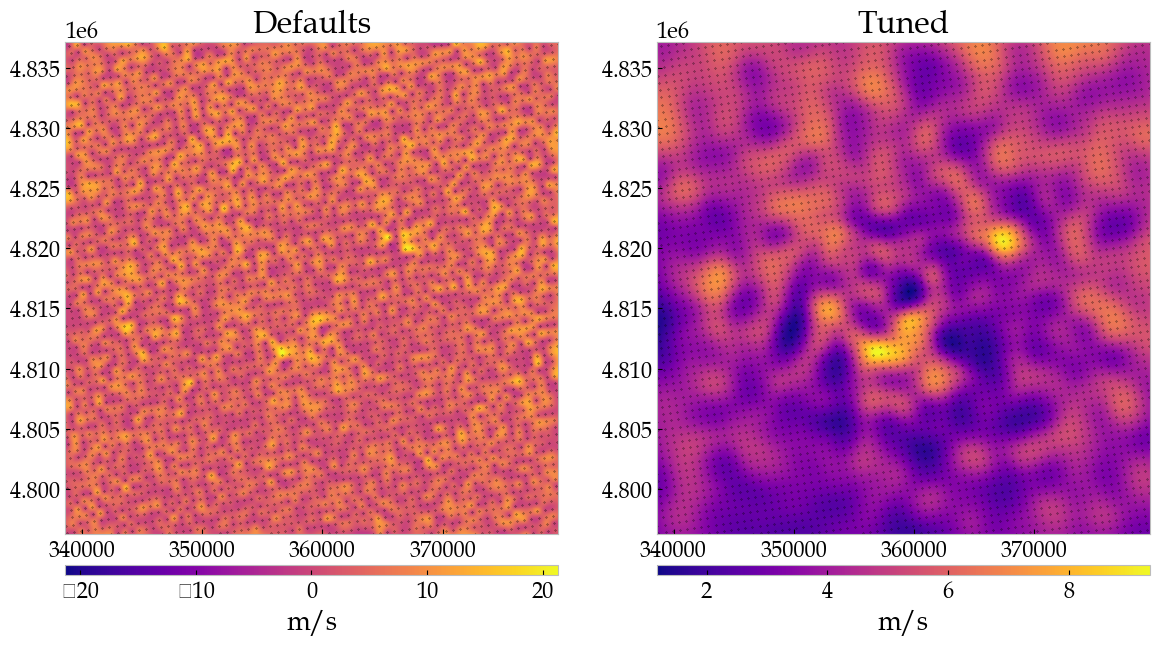

In [46]:
plt.figure(figsize=(14, 8))
for i, title, grd in zip(range(2), ["Defaults", "Tuned"], [grid_default, grid]):
    ax = plt.subplot(1, 2, i + 1)
    ax.set_title(title)
    pc = grd.wind_speed.plot.pcolormesh(
    ax=ax,
    cmap="plasma",
    add_colorbar=False,
    add_labels=False,
    )
    plt.colorbar(pc, orientation="horizontal", aspect=50, pad=0.05).set_label("m/s")
    ax.plot(
        x_wind, y_wind, ".k", markersize=0.5
    )
plt.show()

Notice that, for sparse data like these, smoother models tend to be better predictors. This is a sign that you should probably not trust many of the short wavelength features that we get from the defaults.